##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

##### Original code
https://github.com/MokkeMeguru/glow-realnvp-tutorial/

If you have any Problem, please let me(@MokkeMeguru) it.

In [21]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Bijector: RealNVP x MNIST

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/RealNVP_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/RealNVP_mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example we show how to build a RealNVP using TFP's "Bijector."

# RealNVP x MNIST

# Multivariate normal distribution $\rightarrow$ MNIST

| | Data Dimention|
|----| ----|
| Multivariate normal distribution (2) | n(2)|    
|MNIST | 28 x 28 x 1 |
|CIFER10| h x w x 3|
| Text | Seq_len x Embedding_size ? |

# RealNVP (Multi-Scale Architechture)

## Multi-Scale Architecture
![https://arxiv.org/abs/1410.8516](../img/multi-scale-arch.jpeg)

RealNVP proposes above architecture for the efficient variable conversion.

## Squeezing
![https://arxiv.org/abs/1410.8516](../img/squeezing.jpeg)

||Dimention|
|---|---|
| Input | $h * w * c$ |
| Output | $\cfrac{h}{2} * \cfrac{w}{2} * 4c$ |

In Coupling Layer (RealNVP Bijector), Black is to be $x_a$ , White is to be $x_b$ .

# Problem Setting
Multivariate normal distiribution $\leftrightarrow$ MNIST dataset

# Use Tensorflow

## Implementation Plan
0. Preprocess
1. Create Dataset
2. Build Single-Scale Model
    1. RealNVP Bijector
    2. BatchNormalization Bijector
    3. Permutation Bijector
    3. Squeeze Bijector
    4. Single-Scale Model
3. Build Multi-Scale Model
    1. Blockwise Bijector
    2. Multi-Scale Model
4. Build Model
    1. TransformDistribution
    2. Loss, Optimizar
    3. Training
    4. Inference

## Preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

print('tensorflow: ', tf.__version__)
print('tensorflow-probability: ', tfp.__version__)

tensorflow:  2.0.0-rc0
tensorflow-probability:  0.8.0-rc0


## Create Dataset

### Create Target Distribution ($z$)
In this part, use Multivariate normal distribution

In [2]:
# use Tensorflow's distribution
z = tf.random.normal([2, 2, 256])
print('Tensorflow             : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))
# use Tensorflow Probability's distribution
target_dist = tfd.Normal(loc=0., scale=1.)
z = target_dist.sample([2, 2, 256])
print('Tensorflow Probability : shape: {} mean: {:.6f} sd: {:.6f}'.format(z.shape, tf.math.reduce_mean(z), tf.math.reduce_std(z)))

Tensorflow             : shape: (2, 2, 256) mean: 0.025585 sd: 1.034393
Tensorflow Probability : shape: (2, 2, 256) mean: -0.011340 sd: 1.027189


### Create Original Distribution (MNIST)

In [4]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

print('train_dataset: {} images'.format(len(train_x)))
print('test_dataset : {} images'.format(len(test_x)))

train_dataset: 60000 images
test_dataset : 10000 images


#### Check MNIST dataset

In [42]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

@tf.function
def _parse_function(img, label):
    feature = {}
    img = tf.pad(img, paddings=[[2, 2], [2, 2]], mode="CONSTANT")
    img = tf.expand_dims(img, axis=-1)
    img = tf.reshape(img, [32, 32, 1])
    img = tf.cast(img, dtype=tf.float32)
    img = (img / (255.0 / 2)) - 1
    feature['img'] = img
    feature['label'] = label
    return feature

train_dataset_raw = tf.data.Dataset.from_tensor_slices((train_x, train_y)).map(_parse_function)
test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_x, test_y)).map(_parse_function)

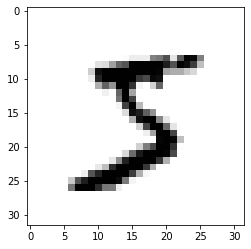

In [43]:
for image_features in train_dataset_raw.take(1):
    plt.imshow(tf.squeeze(image_features['img'], axis=-1), cmap='gray_r')

## Build Single-Scale Model

### RealNVP Bijector

Formula
1. forward function

\begin{eqnarray*}
x_a, x_b &=& split(x) \\
(\log{s}, t) &=& NN(x_b) \\
s &=& exp(\log{s}) \\
y_a &=& s \odot x_a + t \\
y_b &=& x_b \\
y &=& concat(y_a, y_b)
\end{eqnarray*}

2. reverse function

\begin{eqnarray*}
y_a, y_b &=& split(y)\\
(\log{s}, t) &=& NN(y_b)\\
s &=& exp(\log{s})\\
x_a&=& (y_a - t) / s\\
x_b &=& y_b\\
x &=&  concat(x_a, x_b)
\end{eqnarray*}

3. log-determinant

\begin{eqnarray*}
sum(\log{|s|})
\end{eqnarray*}

#### NN Layer
ref. https://github.com/openai/glow/blob/master/model.py#L420-L426 

In [21]:
from tensorflow.keras.layers import Layer, BatchNormalization, ReLU, Conv2D
from tensorflow.keras import Model


class NN(Layer):
    def __init__(
        self,
        input_shape,
        n_hidden=[512, 512],
        kernel_size=[[3, 3], [1, 1]],
        strides=[[1, 1], [1, 1]],
        activation="relu",
        name=None,
    ):
        if name:
            super(NN, self).__init__(name=name)
        else:
            super(NN, self).__init__()
        layer_list = []
        for i, (hidden, kernel, stride) in enumerate(
            zip(n_hidden, kernel_size, strides)
        ):
            layer_list.append(
                Conv2D(
                    hidden,
                    kernel_size=kernel,
                    strides=stride,
                    activation=activation,
                    padding='SAME',
                    name="dense_{}_1".format(i),
                )
            )
        self.layer_list = layer_list
        self.log_s_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            activation="tanh",
            name="log_s",
        )
        self.t_layer = Conv2D(
            input_shape,
            kernel_size=[3, 3],
            strides=[1, 1],
            padding='SAME',
            kernel_initializer="zeros",
            name="t",
        )

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t


def nn_test():
    nn = NN(2, [256, 256])
    x = tf.keras.Input([16, 16, 2])
    log_s, t = nn(x)
    # Non trainable params: -> Batch Normalization's params
    tf.keras.Model(x, [log_s, t], name="nn_test").summary()


nn_test()

Model: "nn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16, 16, 2)]       0         
_________________________________________________________________
nn (NN)                      ((None, 16, 16, 2), (None 79876     
Total params: 79,876
Trainable params: 79,876
Non-trainable params: 0
_________________________________________________________________


#### RealNVP Bijector
ref. https://github.com/openai/glow/blob/master/model.py#L367-L383

In [23]:
class RealNVP(tfb.Bijector):
    def __init__(
        self,
        input_shape,
        forward_min_event_ndims=3,
        validate_args: bool = False,
        name="real_nvp",
        n_hidden=[512, 512],
        **kargs,
    ):
        """
        Args:
            input_shape: 
                input_shape, 
                ex. [28, 28, 3] (image) [2] (x-y vector)
            forward_min_event_ndims:
                this bijector do 
                1. element-wize quantities => 0
                2. vector-wize quantities => 1
                3. matrix-wize quantities => 2
                4. tensor-wize quantities => 3
            n_hidden:
                see. class NN
            **kargs:
                see. class NN
                you can inuput NN's layers parameter here.
        """
        super(RealNVP, self).__init__(
            validate_args=validate_args,
            forward_min_event_ndims=forward_min_event_ndims,
            name=name,
        )

        assert input_shape[-1] % 2 == 0
        self.input_shape = input_shape
        nn_layer = NN(input_shape[-1] // 2, n_hidden)
        nn_input_shape = input_shape.copy()
        nn_input_shape[-1] = input_shape[-1] // 2
        x = tf.keras.Input(nn_input_shape)
        log_s, t = nn_layer(x)
        self.nn = Model(x, [log_s, t], name=self.name + "/nn")

    def _forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)
        y_b = x_b
        log_s, t = self.nn(x_b)
        s = tf.exp(log_s)
        y_a = s * x_a + t
        y = tf.concat([y_a, y_b], axis=-1)
        return y

    def _inverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)
        x_b = y_b
        log_s, t = self.nn(y_b)
        s = tf.exp(log_s)
        x_a = (y_a - t) / s
        x = tf.concat([x_a, x_b], axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        _, x_b = tf.split(x, 2, axis=-1)
        log_s, t = self.nn(x_b)
        return tf.reduce_sum(log_s)


def realnvp_test():
    realnvp = RealNVP(input_shape=[16, 16, 4], n_hidden=[256, 256])
    x = tf.keras.Input([16, 16, 4])
    y = realnvp.forward(x)
    print("trainable_variables :", len(realnvp.trainable_variables))

    flow = tfd.TransformedDistribution(
        event_shape=[16, 16, 4],
        distribution=tfd.Normal(loc=0.0, scale=1.0),
        bijector=realnvp,
    )
    x = flow.sample(64)
    y = realnvp.inverse(x)
    log_prob = flow.log_prob(y)
    print(
        x.shape,
        y.shape,
        log_prob.shape,
    )


realnvp_test()

trainable_variables : 8
(64, 16, 16, 4) (64, 16, 16, 4) (64,)


### BatchNormalization Layer

ref. tensorflow_probability/bijector/BatchNormalization 

### Permutation Bijector
Reverse by Channel dims.
In Glow, it improve this layer to Invertible 1x1 convolution.

In [24]:
class RevPermute(tfb.Bijector):
    def __init__(
        self,
        axis=[-1],
        forward_min_event_ndims=0,
        validate_args=False,
        name="RevPermute",
    ):
        super(RevPermute, self).__init__(
            forward_min_event_ndims=forward_min_event_ndims,
            validate_args=validate_args,
            name=name,
            is_constant_jacobian=True
        )
        self._axis = axis

    @property
    def axis(self):
        return self._axis

    def _forward(self, x):
        return tf.reverse(x, self.axis)

    def _inverse(self, y):
        return tf.reverse(y, self.axis)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)

    def _inverse_log_det_jacobian(self, y):
        return tf.constant(0.0, dtype=y.dtype)


def test_revPermute():
    revPermute = RevPermute()
    x = tf.keras.Input([16, 16, 4])
    y = revPermute.forward(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([2, 16, 16, 4])
    y = revPermute.forward(x)
    z = revPermute.inverse(y)
    flow = tfd.TransformedDistribution(distribution=target_dist, bijector=revPermute)
    print(tf.reduce_mean(flow.log_prob(tf.random.normal([2, 16, 16, 3]))))
    return tf.reduce_sum(z - x)


test_revPermute()

tf.Tensor(-1.4077907, shape=(), dtype=float32)


<tf.Tensor: id=1114, shape=(), dtype=float32, numpy=0.0>

### Squeeze Bijector

In [26]:
class Squeeze3D(tfb.Bijector):
    def __init__(
        self,
        factor=2,
        forward_min_event_ndims=0,
        inverse_min_event_ndims=0,
        validate_args=False,
        name="Squeeze",
    ):
        self._factor = factor
        super(Squeeze3D, self).__init__(
            forward_min_event_ndims=forward_min_event_ndims,
            inverse_min_event_ndims=inverse_min_event_ndims,
            name=name,
            is_constant_jacobian=True
        )

    @property
    def factor(self):
        return self._factor

    def _forward(self, x):
        (H, W, C) = x.shape[1:]
        batch_size = tf.shape(x)[0:1]
        tmp_shape = tf.concat(
            [
                batch_size,
                (H // self.factor, self.factor, W // self.factor, self.factor, C),
            ],
            axis=0,
        )
        output_shape = tf.concat(
            [batch_size, (H // self.factor, W // self.factor, C * self.factor ** 2)],
            axis=0,
        )
        y = tf.reshape(x, tmp_shape)
        y = tf.transpose(y, [0, 1, 3, 5, 2, 4])
        y = tf.reshape(y, output_shape)
        return y

    def _inverse(self, y):
        (H, W, C) = y.shape[1:]
        batch_size = tf.shape(y)[0:1]
        tmp_shape = tf.concat(
            [batch_size, (H, W, C // self.factor ** 2, self.factor, self.factor)], axis=0
        )
        output_shape = tf.concat(
            [batch_size, (H * self.factor, W * self.factor, C // self.factor ** 2)], axis=0
        )
        x = tf.reshape(y, tmp_shape)
        x = tf.transpose(x, [0, 1, 4, 2, 5, 3])
        x = tf.reshape(x, output_shape)
        return x

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0.0, dtype=x.dtype)


def test_squeeze3D():
    factor = 2
    x = tf.Variable([[[1, 2, 5, 6], [3, 4, 7, 8], [9, 10, 13, 14], [11, 12, 15, 16]]])
    x = tf.expand_dims(x, axis=-1)
    squeeze3d = Squeeze3D()
    y = squeeze3d.forward(x)
    z = squeeze3d.inverse(y)
    print(tf.reduce_sum(x - z))
    
    flow = tfd.TransformedDistribution(
        event_shape=[16, 16, 2],
        distribution=tfd.Normal(loc=0., scale=1.),
        bijector=squeeze3d
    )
    x = tf.random.normal([64, 16, 16, 2])
    y = flow.bijector.forward(x)
    log_prob = flow.log_prob(y)
    print(x.shape, y.shape, log_prob.shape)
    

test_squeeze3D()

tf.Tensor(0, shape=(), dtype=int32)
(64, 16, 16, 2) (64, 8, 8, 8) (64,)


### Single-Scale Model

In [27]:
def gen_flow_chain(level=3):
    flow_chain_list = []
    for i in range(level):
        flow_chain_list.append(Squeeze3D())
        flow_chain_list.append(tfb.BatchNormalization())
        flow_chain_list.append(RevPermute()),
        flow_chain_list.append(RealNVP(input_shape=[16, 16, 4], n_hidden=[256, 256])),
        flow_chain_list.append(tfb.Invert(Squeeze3D()))
    return tfb.Chain(list(reversed(flow_chain_list)))  
    
flow_bijector = gen_flow_chain()

flow = tfd.TransformedDistribution(
    event_shape=[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=tfb.Invert(flow_bijector),
)

x = tf.random.normal([64, 32, 32, 1])
log_prob = flow.log_prob(x)
print(log_prob.shape, -tf.reduce_mean(log_prob))

(64,) tf.Tensor(1455.3013, shape=(), dtype=float32)


## Build Multi-Scale Model

### Blockwise Bijector

In [44]:
# ref: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/blockwise.py
class Blockwise3D(tfb.Bijector):
    def __init__(self, bijectors, block_sizes=None, validate_args=False, name=None):
        if not name:
            name = "blockwise3D_of_" + "_and_".join([b.name for b in bijectors])
            name = name.replace("/", "")
        super(Blockwise3D, self).__init__(
            # ???
            forward_min_event_ndims=3,
            validate_args=validate_args,
            name=name,
        )
        self._bijectors = bijectors
        self._block_sizes = block_sizes

    @property
    def bijectors(self):
        return self._bijectors

    @property
    def block_sizes(self):
        return self._block_sizes

    def _forward(self, x):
        split_x = (
            tf.split(x, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(x, self.block_sizes, axis=-1)
        )
        split_y = [b.forward(x_) for b, x_ in zip(self.bijectors, split_x)]
        y = tf.concat(split_y, axis=-1)
        return y

    def _inverse(self, y):
        split_y = (
            tf.split(y, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(y, self.block_sizes, axis=-1)
        )
        split_x = [b.inverse(y_) for b, y_ in zip(self.bijectors, split_y)]
        x = tf.concat(split_x, axis=-1)
        return x

    def _forward_log_det_jacobian(self, x):
        split_x = (
            tf.split(x, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(x, self.block_sizes, axis=-1)
        )
        fldjs = [
            # ???
            b.forward_log_det_jacobian(x_, event_ndims=3)
            for b, x_ in zip(self.bijectors, split_x)
        ]
        return sum(fldjs)

    def _inverse_log_det_jacobian(self, y):
        split_y = (
            tf.split(y, len(self.bijectors), axis=-1)
            if self.block_sizes is None
            else tf.split(y, self.block_sizes, axis=-1)
        )
        ildjs = [
            b.inverse_log_det_jacobian(y_, event_ndims=3)
            for b, y_ in zip(self.bijectors, split_y)
        ]
        return sum(ildjs)


def test_blockwise3D():
    blockwise3D = Blockwise3D(
        bijectors=[
            tfb.Identity(),
            RealNVP(input_shape=[16, 16, 2], n_hidden=[256, 256]),
        ]
    )

    x = tf.keras.Input([16, 16, 4])
    y = blockwise3D.forward(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([3, 16, 16, 4])
    y = blockwise3D.forward(x)
    z = blockwise3D.inverse(y)
    return tf.reduce_sum(z - x)


test_blockwise3D()

<tf.Tensor: id=18997, shape=(), dtype=float32, numpy=0.0>

### Multi-Scale Model

For simplicity, we use below model.
0. Squeeze $[32, 32, 1] \rightarrow [16, 16, 4]$ 
1. Flow-step
2. if not last Flow-step    
    BlockWise3D 
        1. Identity
        2. 0 へ
3. Unsqueeze $[16, 16, 4] \rightarrow [32, 32, 1]$

For example, indicates the transition of L=3.    
In below code, export RealNVP's model architecture to png file.

![](../img//multi-scale-arch.png)

In [29]:
def gen_flowSteps(
    # for realnvp
    input_shape: list,
    n_hidden: list = [256, 256],
    # for flowStep
    k=2,
    forward_min_event_ndims: int = 3,
    validate_args: bool = False,
    name: str = "flow_step",
):
    flow_step_list = []
    for i in range(k):
        flow_step_list.append(tfb.BatchNormalization(validate_args=validate_args))
        flow_step_list.append(RevPermute(validate_args=validate_args)),
        flow_step_list.append(
            RealNVP(
                input_shape=input_shape,
                n_hidden=n_hidden,
                validate_args=validate_args,
                name="{}_{}/realnvp".format(name, i),
            )
        )

    flowSteps = tfb.Chain(
        list(reversed(flow_step_list)), validate_args=validate_args, name=name
    )
    return flowSteps


def test_gen_flowSteps():
    flowSteps = gen_flowSteps(
        k=2, input_shape=[16, 16, 4], forward_min_event_ndims=0, name="flowstep_0"
    )
    x = tf.keras.Input([16, 16, 4])
    y = flowSteps(x)
    # tf.keras.Model(x, y).summary()

    x = tf.random.normal([6, 16, 16, 4])
    y = flowSteps.forward(x)
    z = flowSteps.inverse(y)
    return tf.reduce_sum(z - x)


test_gen_flowSteps()

<tf.Tensor: id=3489, shape=(), dtype=float32, numpy=0.0>

In [30]:
def gen_flow(input_shape, level=3, flow_step_args: dict = None):
    def _gen_input_shapes(input_shape, level):
        input_shape = input_shape
        input_shapes = []
        for i in range(level):
            input_shape = [
                input_shape[0] // 2,
                input_shape[1] // 2,
                input_shape[2] * 4 - i * 8,
            ]
            input_shapes.append(input_shape)
        return input_shapes

    input_shapes = _gen_input_shapes(input_shape, level)

    def _add_flow(_input_shapes, flow_step_args):
        flow_lists = []
        flow_lists.append(
            Squeeze3D(name="Squeeze_{}".format(level - len(_input_shapes)))
        )
        flowSteps = gen_flowSteps(
           k=2,
           input_shape=_input_shapes[0],
           name="Flowsteps_{}".format(level - len(_input_shapes)),
        )
        flow_lists.append(flowSteps)
        if len(_input_shapes) != 1:
            flow_lists.append(
                Blockwise3D(
                    [
                        tfb.Identity(),
                        tfb.Chain(
                            list(reversed(_add_flow(_input_shapes[1:], flow_step_args)))
                        ),
                    ],
                    name="Blockwise3D_{}".format(level - len(_input_shapes)),
                )
            )
        flow_lists.append(
            tfb.Invert(
                Squeeze3D(name="Unsqueeze_{}".format(level - len(_input_shapes)))
            )
        )
        return flow_lists

    return tfb.Chain(list(reversed(_add_flow(input_shapes, level))))


def test_gen_flow():
    flow = gen_flow([32, 32, 1])
    print(len(flow.trainable_variables))
    x = tf.keras.Input([32, 32, 1])
    y = flow.forward(x)
    # tf.keras.Model(x, y).summary()
    tf.keras.utils.plot_model(
        tf.keras.Model(x, y), show_shapes=True, to_file="realnvp.png"
    )
    x = tf.random.normal([3, 32, 32, 1])
    y = flow.forward(x)
    z = flow.inverse(y) 
    return tf.reduce_sum(z - x)

test_gen_flow()

48


<tf.Tensor: id=5637, shape=(), dtype=float32, numpy=0.0>

## Build Model

### TransformDistribution

In [48]:
flow_bijector = gen_flow([32, 32, 1])
print(len(flow_bijector.trainable_variables))
flow = tfd.TransformedDistribution(
    event_shape =[32, 32, 1],
    distribution=tfd.Normal(loc=0.0, scale=1.0),
    bijector=flow_bijector
)
print('trainable_variables: ', len(flow.bijector.trainable_variables))

48
trainable_variables:  48


### Loss, Optimizar

In [32]:
# !rm -r checkpoints

In [49]:
@tf.function
def loss():
    return - tf.reduce_mean(flow.log_prob(targets['img']))


optimizer = tf.optimizers.Adam(learning_rate=1e-4) 
# log = tf.summary.create_file_writer('checkpoints')
avg_loss = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [50]:
BATCH_SIZE=64
train_dataset = train_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
for target in train_dataset.take(1):
    targets = target
print(targets['img'].shape)
with tf.GradientTape() as tape:
    log_prob_loss = loss()
grads = tape.gradient(log_prob_loss, flow.trainable_variables)
print(log_prob_loss)

(64, 32, 32, 1)
tf.Tensor(826.2821, shape=(), dtype=float32)


### Training

In [51]:
n_epochs = 30

for epoch in range(n_epochs):
    for targets in train_dataset:
        with tf.GradientTape() as tape:
            log_prob_loss = loss()
        grads = tape.gradient(log_prob_loss, flow.trainable_variables)
        optimizer.apply_gradients(zip(grads, flow.trainable_variables))
        avg_loss.update_state(log_prob_loss)
        if tf.equal(optimizer.iterations % 1000, 0):
            print("Step {} Loss {:.6f}".format(optimizer.iterations, avg_loss.result()))
        if tf.equal(optimizer.iterations % 100, 0):
            # with log.as_default():
            #     tf.summary.scalar("loss", avg_loss.result(), step=optimizer.iterations)
            #     avg_loss.reset_states()
            avg_loss.reset_states()

Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=1000> Loss -113248.062500
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=2000> Loss -113989.187500
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=3000> Loss -114157.593750
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=4000> Loss -114258.070312
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=5000> Loss -114342.117188
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=6000> Loss -114492.078125
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=7000> Loss -114595.812500
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=8000> Loss -114729.562500
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=9000> Loss -114821.367188
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=10000> Loss -114956.937500
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=11000> Loss -115009.398438
Step <tf.Variable 'Adam/iter:0' shape=() dtype=int64

### Inference

In [53]:
test_dataset = test_dataset_raw.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

log probability:  -2.404663
inv mean:  -1.7276034e-07  std:  1.7237891
re:trg mean:  -0.79402995  std:  0.5574867
(1, 32, 32, 1)


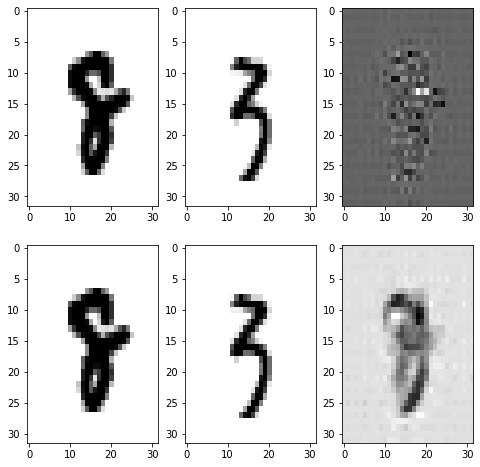

In [65]:
fig = plt.figure(figsize=(8, 8))
for targets in test_dataset.take(1):
    trg = targets["img"]
    inv = flow.bijector.inverse(trg)
    re_trg = flow.bijector.forward(inv)

print('log probability: ', tf.reduce_mean(tfd.Normal(0., 1.).log_prob(inv)).numpy())
print("inv mean: ", tf.reduce_mean(inv).numpy(), " std: ", tf.math.reduce_std(inv).numpy())
print("re:trg mean: ", tf.reduce_mean(re_trg).numpy(), " std: ", tf.math.reduce_std(re_trg).numpy())

re_inv = np.array([(inv[0] + inv[1]) / 2.0])
print(re_inv.shape)
re_re_trg = flow.bijector.forward(re_inv)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(tf.squeeze(trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 4)
ax.imshow(tf.squeeze(re_trg[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 2)
ax.imshow(tf.squeeze(trg[1], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 5)
ax.imshow(tf.squeeze(re_trg[1], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 3)
ax.imshow(tf.squeeze(re_inv[0], axis=-1), aspect="auto", cmap="gray_r")

ax = fig.add_subplot(2, 3, 6)
ax.imshow(tf.squeeze(re_re_trg[0], axis=-1), aspect="auto", cmap="gray_r")